In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
import torchvision.transforms.v2 as transforms 
import torch.optim as optim
import wandb

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.cuda.manual_seed_all(42)
np.random.seed(42)

wandb.login()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
config = dict(
    epochs=10,
    batch_size=32,
    learning_rate=0.001,
    dataset="WildlifeClassification",
    num_classes=10
)

run = wandb.init(project="wildlife-classification", config=config)

wandb: Currently logged in as: aakarsh21507. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240221_143842-3oxlgaz0
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run golden-tiger-6
wandb: ⭐️ View project at https://wandb.ai/aakarsh21507/wildlife-classification
wandb: 🚀 View run at https://wandb.ai/aakarsh21507/wildlife-classification/runs/3oxlgaz0


In [3]:
class WildlifeDataset(Dataset):
    def __init__(self, dir, transform=transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])):
        super().__init__()
        self.transform = transform
        self.data = datasets.ImageFolder(dir, transform=self.transform)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        y = self._adjust_class_ids(y)
        return x, y

    def _adjust_class_ids(sefl, y):
        # people class is required to be 9, but is 6 in the dataset
        if y > 6:
            y -= 1
        elif y == 6:
            y = 9
        return y

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [4]:
dataset = WildlifeDataset('/kaggle/input/cv-hw1/Wildlife_dataset/Cropped_final/')

train_ratio, val_ratio, test_ratio = 0.7, 0.1, 0.2
train_size = int(len(dataset) * train_ratio)
val_size = int(len(dataset)  * val_ratio)
test_size = int(len(dataset) - train_size - val_size)

train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_data, batch_size=config['batch_size'], shuffle=True)
test_loader = DataLoader(test_data, batch_size=config['batch_size'], shuffle=True)

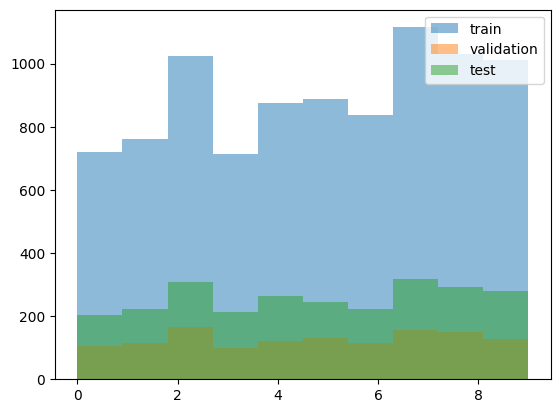

In [5]:
# Get the labels from the dataset
train_labels = [label for _, label in train_data]
val_labels = [label for _, label in val_data]
test_labels = [label for _, label in test_data]

plt.hist(train_labels, bins=10, alpha=0.5, label='train')
plt.hist(val_labels, bins=10, alpha=0.5, label='validation')
plt.hist(test_labels, bins=10, alpha=0.5, label='test')

plt.legend(loc='upper right')
plt.show()

In [6]:
class CNN(nn.Module):
    def __init__(self,num_classes:int) -> None:
        super(CNN, self).__init__()
        self.conv_layer_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.max_pool_1 = nn.MaxPool2d(kernel_size=4, stride=4)

        self.conv_layer_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1,padding=1)
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_layer_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.max_pool_3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128*16*16, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        out1 = self.conv_layer_1(x)
        out1 = self.relu(out1)
        out1 = self.max_pool_1(out1)

        out2 = self.conv_layer_2(out1)
        out2 = self.relu(out2)
        out2 = self.max_pool_2(out2)

        out3 = self.conv_layer_3(out2)
        out3 = self.relu(out3)
        out3 = self.max_pool_3(out3)

        out4 = out3.view(-1, 128*16*16)
        out4 = self.fc1(out4)

        return out4

In [7]:
model = CNN(num_classes=config['num_classes'])
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

In [8]:
for _ in range(config['epochs']):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for (images, labels) in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels.data).sum().item()
    
    training_accuracy = 100 * correct_train / total_train
    training_loss = running_loss / len(train_loader)

    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for (images, labels) in val_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)

            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels.data).sum().item()

    validation_accuracy = 100 * correct_val / total_val
    validation_loss = running_loss / len(val_loader)

    wandb.log({"Training Loss": training_loss, "Training Accuracy": training_accuracy, "Validation Loss": validation_loss, "Validation Accuracy": validation_accuracy})

In [10]:
from sklearn.metrics import f1_score, confusion_matrix

# Test the model
model.eval()
correct_test = 0
total_test = 0

# log the f1 score
y_true = []
y_pred = []


with torch.no_grad():
    for (images, labels) in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels.data).sum().item()
        y_true += labels.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()


test_accuracy = 100 * correct_test / total_test
wandb.log({"Test Accuracy": test_accuracy})


f1 = f1_score(y_true, y_pred, average='weighted')
wandb.log({"f1_score": f1})

# log the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                y_true=y_true, preds=y_pred,
                                class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])})

In [11]:
from torchvision.models import resnet18
import torchvision.models.resnet

model_resnet = resnet18(weights=torchvision.models.resnet.ResNet18_Weights.IMAGENET1K_V1)

for param in model_resnet.parameters():
    param.requires_grad = False
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, config['num_classes'])

model_resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.fc.parameters(), lr=config['learning_rate'])

for epoch in range(config['epochs']):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = 100 * running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    model_resnet.eval()
    running_loss = 0.0
    correct_eval = 0
    total_eval = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_resnet(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_eval += labels.size(0)
            correct_eval += (predicted == labels).sum().item()

    val_loss = 100 * running_loss / len(val_loader)
    val_accuracy = 100 * correct_eval / total_eval
    
    
    wandb.log({"Training Loss Resnet18": train_loss, "Training Accuracy Resnet18": train_accuracy, "Validation Loss Resnet18": val_loss, "Validation Accuracy Resnet18": val_accuracy})

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s]


In [12]:
torch.save(model_resnet.state_dict(), "wildlife_model_resnet18.pth")

In [13]:
from sklearn.metrics import f1_score, confusion_matrix

model_resnet.eval()

correct_test = 0
total_test = 0
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        y_true += labels.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()


test_accuracy = 100 * correct_test / total_test
wandb.log({"Test Accuracy Resnet18": test_accuracy})

f1 = f1_score(y_true, y_pred, average='weighted')
wandb.log({"f1_score Resnet18": f1})

conf_matrix = confusion_matrix(y_true, y_pred)
wandb.log({"confusion_matrix Resnet18": wandb.plot.confusion_matrix(probs=None,
                                y_true=y_true, preds=y_pred,
                                class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])})


In [14]:
wandb.finish()

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                Test Accuracy ▁
wandb:       Test Accuracy Resnet18 ▁
wandb:            Training Accuracy ▁▃▄▅▆▆▇███
wandb:   Training Accuracy Resnet18 ▁▅▆▇▇█████
wandb:                Training Loss █▆▅▄▃▃▂▁▁▁
wandb:       Training Loss Resnet18 █▄▃▂▂▂▁▁▁▁
wandb:          Validation Accuracy ▁▄▆▇████▇▇
wandb: Validation Accuracy Resnet18 ▁▆▇▆▇▇▇██▇
wandb:              Validation Loss ▅▃▂▁▂▂▃▄▇█
wandb:     Validation Loss Resnet18 █▄▂▂▂▃▁▁▂▁
wandb:                     f1_score ▁
wandb:            f1_score Resnet18 ▁
wandb: 
wandb: Run summary:
wandb:                Test Accuracy 61.73032
wandb:       Test Accuracy Resnet18 81.60561
wandb:            Training Accuracy 92.55876
wandb:   Training Accuracy Resnet18 84.44915
wandb:                Training Loss 0.24869
wandb:       Training Loss Resnet18 44.78255
wandb:          Validation Accuracy 60.53042
wandb: Validati

In [15]:
# Extracting the features from the model
from sklearn.manifold import TSNE

features = []
labels = []



model_resnet.eval()

def extract_features(model, dataloader):
    features = []
    labels = []
    with torch.no_grad():
        for images, label in dataloader:
            images = images.to(device)
            labels.extend(label.numpy())
            output = model_resnet(images)
            features.extend(output.cpu().numpy())
    return features, labels

train_features, train_labels = extract_features(model_resnet, train_loader)


/tmp/ipykernel_27/3295156710.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:261.)
  train_features = torch.tensor(train_features)


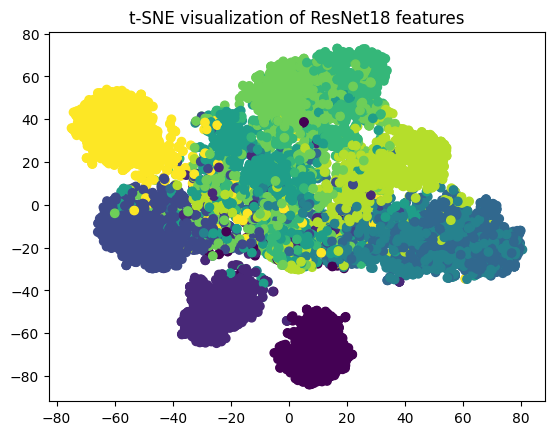

In [16]:
train_features = torch.tensor(train_features)
train_labels = torch.tensor(train_labels)

tsne = TSNE(n_components=2, random_state=42)
train_tsne = tsne.fit_transform(train_features)

plt.scatter(train_tsne[:, 0], train_tsne[:, 1], c=train_labels, cmap='viridis')
plt.title('t-SNE visualization of ResNet18 features')
plt.show()

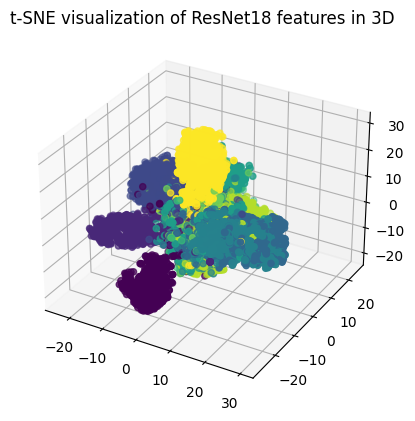

In [17]:
# visualize the features of the model using t-SNE in 3D
tsne_3d = TSNE(n_components=3, random_state=42)

train_tsne_3d = tsne_3d.fit_transform(train_features)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_tsne_3d[:, 0], train_tsne_3d[:, 1], train_tsne_3d[:, 2], c=train_labels, cmap='viridis')
plt.title('t-SNE visualization of ResNet18 features in 3D')
plt.show()

In [18]:
# Define the data augmentation transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomVerticalFlip(),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


augmented_dataset = WildlifeDataset('/kaggle/input/cv-hw1/Wildlife_dataset/Cropped_final/', transform=transform)
normal_dataset = WildlifeDataset('/kaggle/input/cv-hw1/Wildlife_dataset/Cropped_final/')

# sample 20% from the augmented dataset and add it to the normal dataset
augmented_data_size = int(len(augmented_dataset) * 0.1)
augmented_data, _ = torch.utils.data.random_split(augmented_dataset, [augmented_data_size, len(augmented_dataset) - augmented_data_size])

combined_dataset = torch.utils.data.ConcatDataset([normal_dataset, augmented_data])

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [19]:
new_train_data_size = int(len(combined_dataset) * 0.7)
new_test_data_size = int(len(combined_dataset) * 0.2)
new_val_data_size = len(combined_dataset) - new_train_data_size - new_test_data_size

train_data_augmented, val_data_augmented, test_data_augmented = torch.utils.data.random_split(combined_dataset, [new_train_data_size, new_val_data_size, new_test_data_size])

train_loader_augmented = DataLoader(train_data_augmented, batch_size=config['batch_size'], shuffle=True)
val_loader_augmented = DataLoader(val_data_augmented, batch_size=config['batch_size'], shuffle=True)
test_loader_augmented = DataLoader(test_data_augmented, batch_size=config['batch_size'], shuffle=True)

In [20]:
model_augmented = CNN(num_classes=config['num_classes'])
model_augmented.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_augmented.parameters(), lr=config['learning_rate'])

In [21]:
run = wandb.init(project="wildlife-classification", config=config)

for _ in range(config['epochs']):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for (images, labels) in train_loader_augmented:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model_augmented(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels.data).sum().item()
    
    training_accuracy = 100 * correct_train / total_train
    training_loss = running_loss / len(train_loader_augmented)

    model_augmented.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for (images, labels) in val_loader_augmented:
            images, labels = images.to(device), labels.to(device)
            output = model_augmented(images)
            loss = criterion(output, labels)

            running_loss += loss.item() 
            _, predicted = torch.max(output.data, 1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels.data).sum().item()

    validation_accuracy = 100 * correct_val / total_val
    validation_loss = running_loss / len(val_loader_augmented)

    wandb.log({"Training Loss Augmented": training_loss, "Training Accuracy Augmented": training_accuracy, "Validation Loss Augmented": validation_loss, "Validation Accuracy Augmented": validation_accuracy})

wandb: wandb version 0.16.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240221_151942-r1dhzyyp
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run scintillating-springroll-7
wandb: ⭐️ View project at https://wandb.ai/aakarsh21507/wildlife-classification
wandb: 🚀 View run at https://wandb.ai/aakarsh21507/wildlife-classification/runs/r1dhzyyp


In [22]:
wandb.finish()

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:   Training Accuracy Augmented ▁▃▄▅▆▆▇▇██
wandb:       Training Loss Augmented █▆▅▄▃▃▂▂▁▁
wandb: Validation Accuracy Augmented ▁▄▆▇▇██▇██
wandb:     Validation Loss Augmented █▅▄▂▁▁▁▂▁▃
wandb: 
wandb: Run summary:
wandb:   Training Accuracy Augmented 86.55054
wandb:       Training Loss Augmented 0.44212
wandb: Validation Accuracy Augmented 65.58074
wandb:     Validation Loss Augmented 1.26278
wandb: 
wandb: 🚀 View run scintillating-springroll-7 at: https://wandb.ai/aakarsh21507/wildlife-classification/runs/r1dhzyyp
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240221_151942-r1dhzyyp/logs


In [23]:
run = wandb.init(project="wildlife-classification", config=config)

model_augmented.eval()

correct_test = 0
total_test = 0
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader_augmented:
        images, labels = images.to(device), labels.to(device)
        outputs = model_augmented(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        y_true += labels.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()


test_accuracy = 100 * correct_test / total_test
wandb.log({"Test Accuracy Augmented": test_accuracy})

f1 = f1_score(y_true, y_pred, average='weighted')
wandb.log({"f1_score Augmented": f1})

conf_matrix = confusion_matrix(y_true, y_pred)

wandb.log({"confusion_matrix Augmented": wandb.plot.confusion_matrix(probs=None,
                                y_true=y_true, preds=y_pred,
                                class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])})

wandb.finish()

wandb: wandb version 0.16.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240221_153933-mph59w28
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run twinkling-dog-8
wandb: ⭐️ View project at https://wandb.ai/aakarsh21507/wildlife-classification
wandb: 🚀 View run at https://wandb.ai/aakarsh21507/wildlife-classification/runs/mph59w28
wandb:                                                                                
wandb: 
wandb: Run history:
wandb: Test Accuracy Augmented ▁
wandb:      f1_score Augmented ▁
wandb: 
wandb: Run summary:
wandb: Test Accuracy Augmented 62.53102
wandb:      f1_score Augmented 0.62734
wandb: 
wandb: 🚀 View run twinkling-dog-8 at: https://wandb.ai/aakarsh21507/wildlife-classification/runs/mph59w28
wandb: Synced 5 W&B file(s), 1 media file(s), 1 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./